# Exploratory Data Analysis of news articles dataset
Contributions: EDA conducted by Shaun, Samson and Yu Xiang, dataset compiled by news articles data scraping team

In [28]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re
import nltk
#nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from dateutil import parser

In [2]:
df = pd.read_csv('news_articles_cleanedv5.csv')
df.head()

title  \
0  'It took months to see the end of the tunnel':...   
1  'Everyone watching makes me feel uneasy': Stud...   
2  Singapore Mental Health Film Festival 2021 ret...   
3  Woman, 19, rescued after sitting on 27th-floor...   
4  'I wanted to push the aircon out and jump down...   

                                                 url tags        date  \
0  https://www.asiaone.com/lifestyle/it-took-mont...  NIL  05/06/2021   
1  https://www.asiaone.com/singapore/everyone-wat...  NIL  01/06/2021   
2  https://www.asiaone.com/lifestyle/singapore-me...  NIL  18/05/2021   
3  https://www.asiaone.com/singapore/woman-19-res...  NIL  09/04/2021   
4  https://www.asiaone.com/lifestyle/i-wanted-pus...  NIL  09/01/2021   

                                             content  covid news_source  
0  When she first started gymnastics at the age o...  False    Asia One  
1  These days, Natasha Osman would sit in front o...  False    Asia One  
2  The Covid-19 pandemic has heightened concerns ...   True    Asia One  
3  Residents in Sengkang craned their necks as th...  False    Asia One  
4  In his 30s and at the peak of his life and car...  False    Asia One

## Data cleaning
(contributed by Shaun and Yu Xiang)

In [3]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y') #datetime conversion

In [4]:
# Removing URLs, non-alphabets, stopwords (incld custom ones) + lemmatise words

nltk_stopwords = nltk.corpus.stopwords.words('english')
nltk_stopwords.extend(['á', "s","â","singapore","singaporean","sâ", "will", "said","one", 'could', 'would', 'may', 'also', 'say', 'like'])

def text_processor(text):
    # Remove HTML Tags
    try:
        text = html.document_fromstring(text).text_content()
    except:
        pass

    text = text.lower() #lower case
    text = re.sub(r'http\S+', '', text) #remove urls
    text = re.sub('[^a-zA-Z ]+', ' ', text) #remove non-alphabets
    # text = "".join([i for i in text if i not in string.punctuation]) #remove punctuations
    tokens  = re.split(' ', text) #split str into list
    tokens = [t for t in tokens if (t not in nltk_stopwords) and (len(t) > 2)] #remove stopwords and words less than 3 letters

    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatised = [wordnet_lemmatizer.lemmatize(word) for word in tokens] #lemmatise

    output = " ".join(word for word in lemmatised)

    return output

df['cleaned_content'] = df['content'].apply(text_processor)

In [5]:
# Example of before/after (first article):
print(df['content'][0][:200])
print("")
print(df['cleaned_content'][0][:200])

When she first started gymnastics at the age of eight, Joy Koh recalls being mesmerised by cartwheels and splits. But she was soon hit with a reality check. Subscribing to the "no pain, no gain" minds

first started gymnastics age eight joy koh recall mesmerised cartwheel split soon hit reality check subscribing pain gain mindset coach body shame push beyond limit year old tell asiaone child cry puk


## Basic EDA
(contributed by Shaun, Yu Xiang and Samson)

Total number of articles: 977.
Covid-related: 736; non-covid-related: 241
Date range of articles: 2018-03-30 to 2021-07-12
Type of news source: ['Asia One' 'Mothership' 'Nikkei Asia' 'Stress & Health' 'The Economist'
 'HRD' 'BioSpectrum' 'deccanherald' 'Human Resource Online' 'Dovepress'
 'CTV News' 'Nature' 'NDTV' 'Wired' 'Asia Insurance' 'Talter' 'KrAsia'
 'The 47' 'Insurance Business' 'TNP SG' 'Rice Media' 'Straits Times' 'CNA'
 'Today Online']


Text(0.5, 1.0, 'Distribution of news articles')

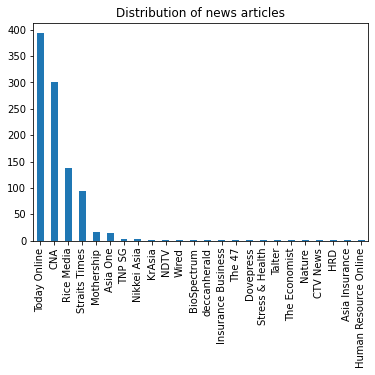

In [6]:
# Basic EDA + Distribution of news articles, by source
print("Total number of articles: {}.\nCovid-related: {}; non-covid-related: {}".format(len(df), sum(df['covid']), len(df)-sum(df['covid'])))
print("Date range of articles: {} to {}".format(str(min(df['date']))[:10], str(max(df['date']))[:10]))
print("Type of news source: {}".format(df.news_source.unique()))

ax = df['news_source'].value_counts().plot(kind='bar')
ax.set_title('Distribution of news articles')

Text(0.5, 1.0, 'Monthly count of news articles')

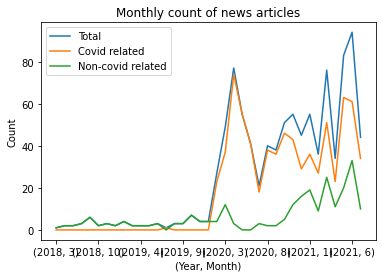

In [7]:
# Count of news articles over time, split by covid-related and otherwise
count_date_all = df['date'].groupby([df.date.dt.year, df.date.dt.month]).agg('count') #df containing monthly count of articles
count_date_covid = df[df['covid']]['date'].groupby([df.date.dt.year, df.date.dt.month]).agg('count')
count_date_non_covid =df[~df['covid']]['date'].groupby([df.date.dt.year, df.date.dt.month]).agg('count')

count_df = pd.concat([count_date_all,count_date_covid, count_date_non_covid], axis=1)
count_df.columns = ['Total','Covid related','Non-covid related']
count_df.replace(np.NaN, 0, inplace=True)

ax = count_df.plot(kind='line')
ax.set_ylabel('Count')
ax.set_xlabel('(Year, Month)')
ax.set_title('Monthly count of news articles')

# for n, label in enumerate(ax.xaxis.get_ticklabels()):
#     print(n,label)

In [8]:
kws = ['depression', 'mental illness', 'unalive' , 'social anxiety', 'loneliness',
'stress', 'lonely', 'isolation', 'suicide', 'abuse', 'death', 'post traumatic stress disorder',
'no motivation', 'therapy', 'trauma', 'counselling', 'mood disorder', 'mood swings',
'mental health', 'angst', 'emotion', 'phobia', 'addiction', 'stigma', 'self-harm',
'neurosis', 'disorder', 'dependence', 'socialize', 'help', 'dead', 'melancholia',
'dysthemia', 'tired', 'trapped', 'paranoia', 'overwhelmed', 'irritable', 'bipolar', 'psychologist', 'well-being',
'imh', 'sos', 'counsellor', 'toxic', 'insominia', 'drugs', 'fight','self-esteem']

#counting number of articles/titles containing keyword (+1 if appear in article at least once)
def kws_count(df_series, kws):
    data = {}
    for article in df_series:
        for kw in kws:
            if kw not in data:
                data[kw] = 0
            if kw in article.lower():
                data[kw] += 1

    print(data)

    df_count = pd.DataFrame(data.items(), columns = ["keywords","count"])
    df_count = df_count.sort_values("count",ascending = False)
    return df_count

print('Number of articles containing keyword')
kw_count_in_content_df = kws_count(df['content'], kws) 
print("")
print('Number of article titles containing keyword')
kw_count_in_title_df = kws_count(df['title'], kws)

Number of articles containing keyword
{'depression': 149, 'mental illness': 72, 'unalive': 0, 'social anxiety': 5, 'loneliness': 44, 'stress': 406, 'lonely': 31, 'isolation': 133, 'suicide': 114, 'abuse': 149, 'death': 175, 'post traumatic stress disorder': 1, 'no motivation': 1, 'therapy': 104, 'trauma': 59, 'counselling': 159, 'mood disorder': 8, 'mood swings': 9, 'mental health': 499, 'angst': 11, 'emotion': 234, 'phobia': 36, 'addiction': 30, 'stigma': 127, 'self-harm': 34, 'neurosis': 0, 'disorder': 147, 'dependence': 39, 'socialize': 0, 'help': 690, 'dead': 77, 'melancholia': 0, 'dysthemia': 0, 'tired': 78, 'trapped': 32, 'paranoia': 11, 'overwhelmed': 46, 'irritable': 3, 'bipolar': 34, 'psychologist': 122, 'well-being': 199, 'imh': 97, 'sos': 47, 'counsellor': 89, 'toxic': 56, 'insominia': 0, 'drugs': 35, 'fight': 116, 'self-esteem': 12}

Number of article titles containing keyword
{'depression': 2, 'mental illness': 6, 'unalive': 0, 'social anxiety': 0, 'loneliness': 2, 'stress

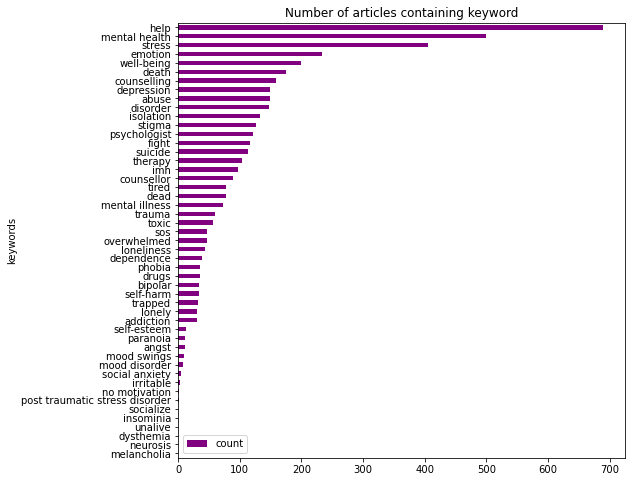

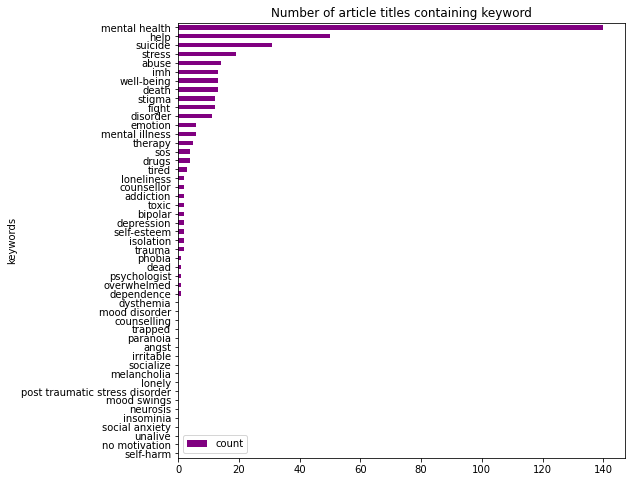

In [9]:
#plot horizontal bar graph of keyword counts
def kws_graph(kw_count_df, title):
    fig, ax = plt.subplots(figsize=(8, 8))

    kw_count_df.sort_values("count").plot.barh(x='keywords',
                      y='count',
                      ax=ax,
                      color="purple")

    ax.set_title(title)
    plt.show()

kws_graph(kw_count_in_content_df, "Number of articles containing keyword")
kws_graph(kw_count_in_title_df, "Number of article titles containing keyword")

## Word Cloud
(contributed by Samson and Shaun)

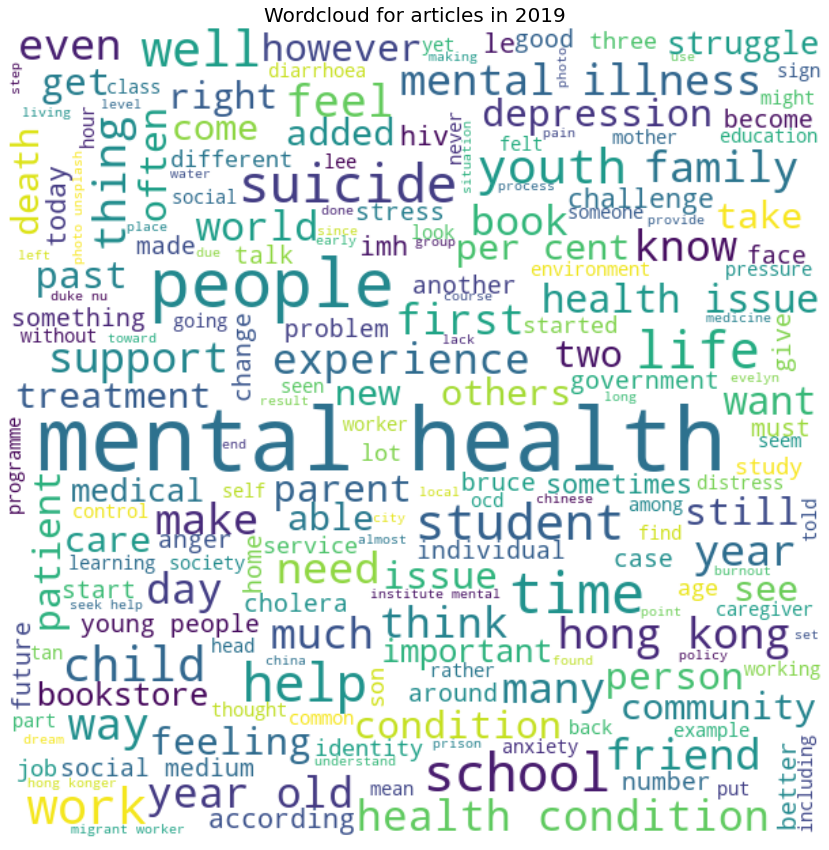

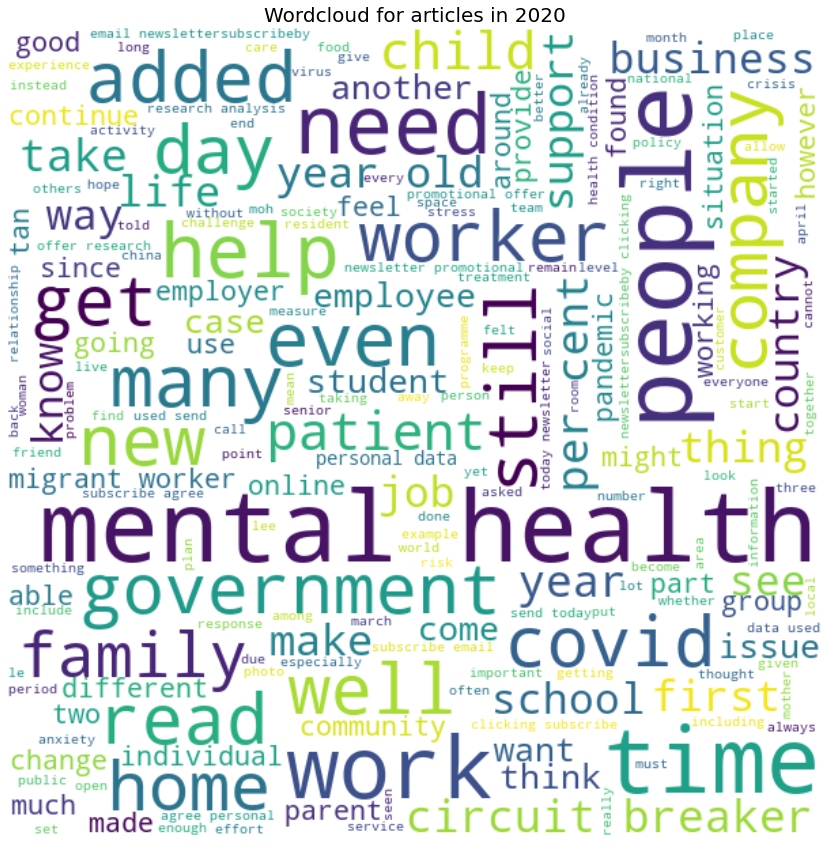

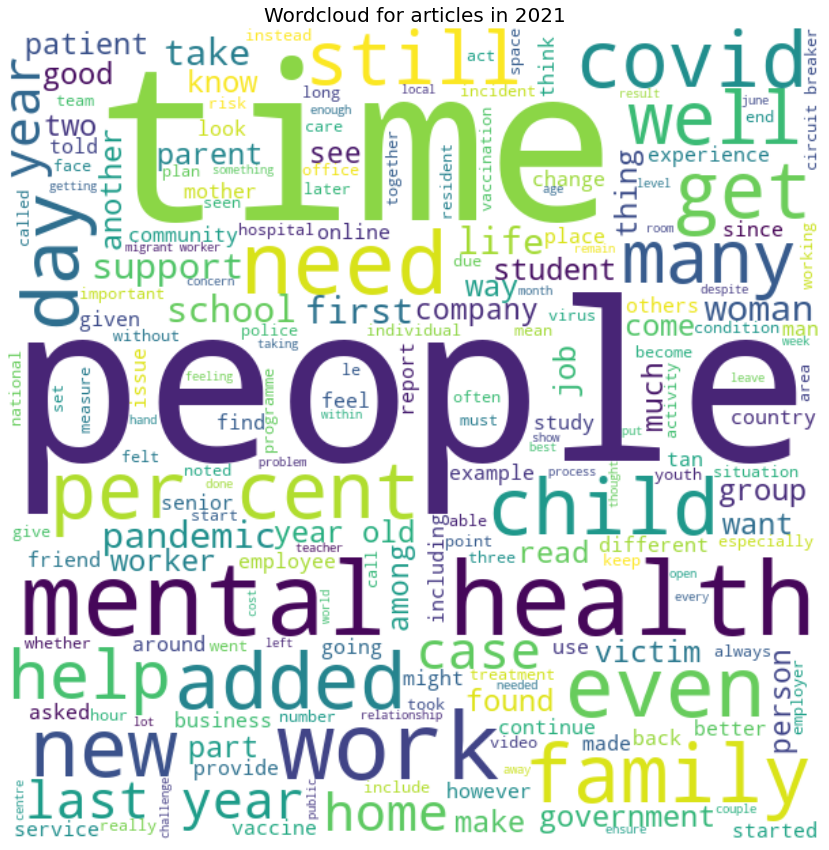

In [10]:
# filter articles by year (contributed by Shaun and Samson)
articles_2019 = df[(df.date >= parser.parse("01 Jan 2019")) & (df.date <= parser.parse("31 Dec 2019"))]
articles_2020 = df[(df.date >= parser.parse("01 Jan 2020")) & (df.date <= parser.parse("31 Dec 2020"))]
articles_2021 = df[(df.date >= parser.parse("01 Jan 2021")) & (df.date <= parser.parse("31 Dec 2021"))]


def create_wordcloud(text_series, title):
    
    wc = WordCloud(background_color = 'white', stopwords=nltk_stopwords, height = 600, width = 600)
    words = ' '.join(w for w in text_series)
    wc.generate(words)

    plt.figure(figsize=(15,15))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize= 20)
    plt.axis('off')
    plt.show()

create_wordcloud(articles_2019['cleaned_content'], 'Wordcloud for articles in 2019')
create_wordcloud(articles_2020['cleaned_content'], 'Wordcloud for articles in 2020')
create_wordcloud(articles_2021['cleaned_content'], 'Wordcloud for articles in 2021') 

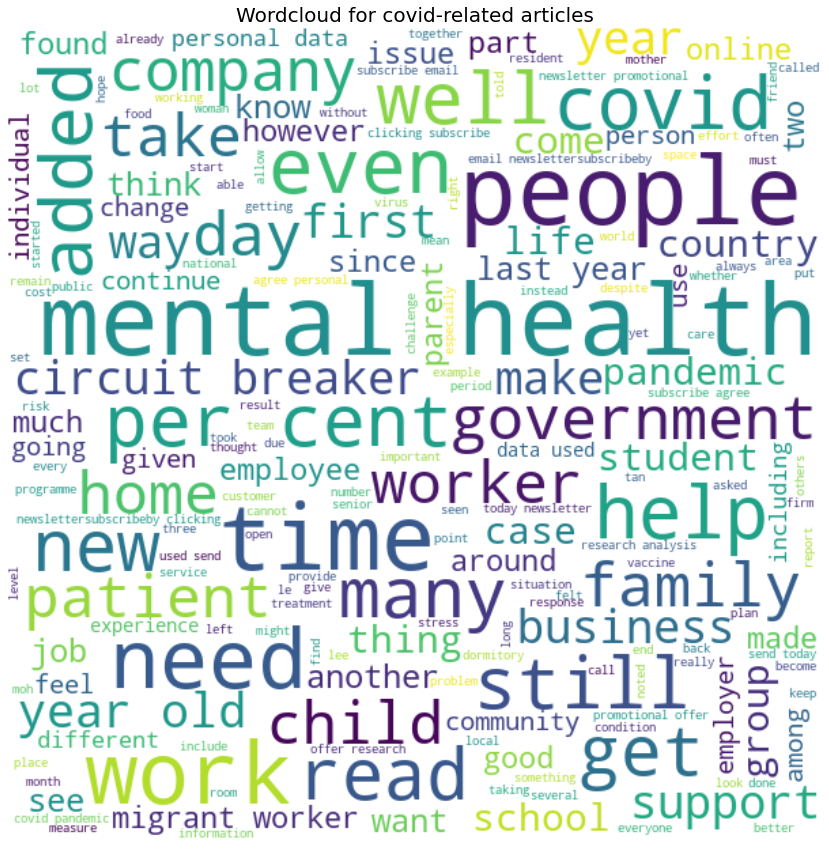

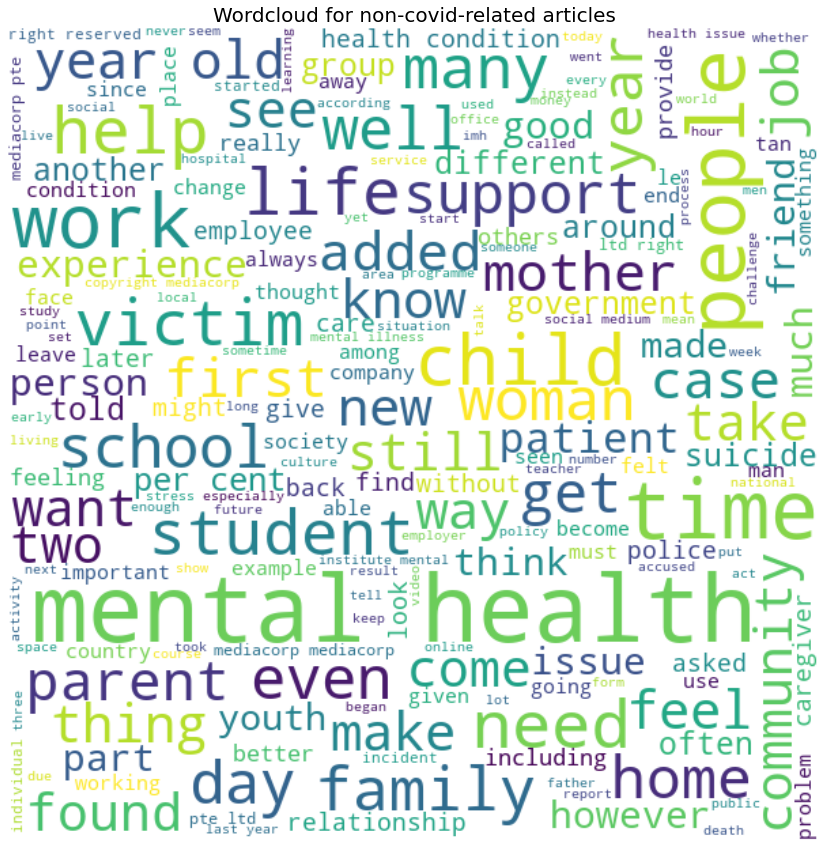

In [11]:
covid_articles = df[df['covid']]
non_covid_articles = df[~df['covid']]
create_wordcloud(covid_articles['cleaned_content'], 'Wordcloud for covid-related articles')
create_wordcloud(non_covid_articles['cleaned_content'], 'Wordcloud for non-covid-related articles')

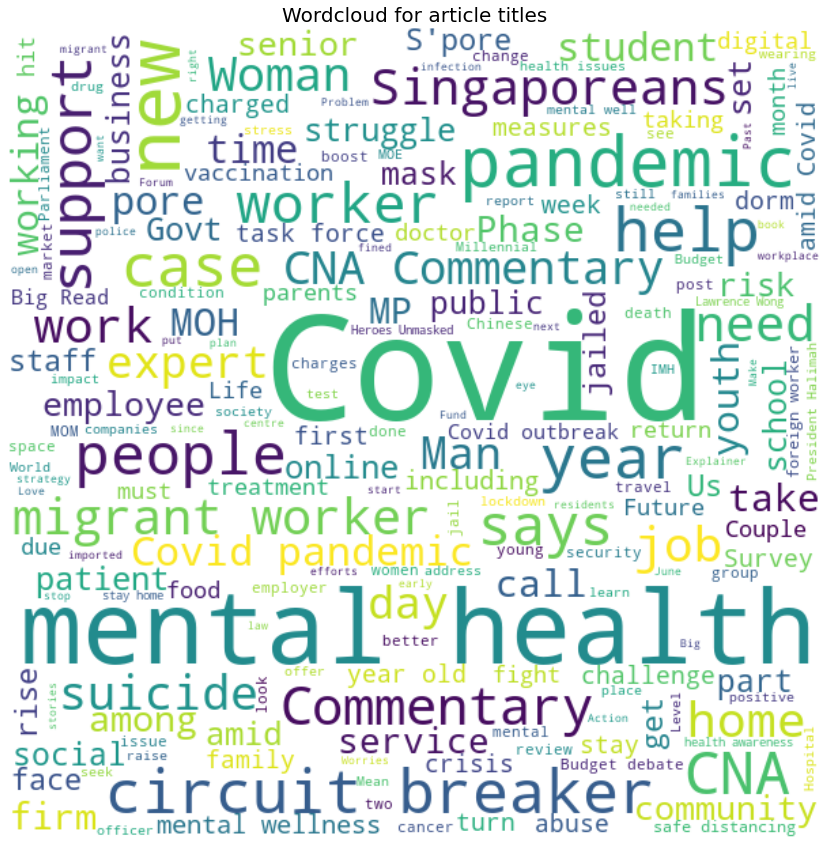

In [12]:
create_wordcloud(covid_articles['title'], 'Wordcloud for article titles')

## Topic Modelling (using LDA)
(contributed by Yu Xiang)

In [13]:
#LDA viz for topic modelling
def lda_viz(df_series, num_topics):
    corpus = df_series.apply(lambda x: x.split()) # corpus is a list of list of words
    
    dic = gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]

    lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = num_topics, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    print(lda_model.show_topics())
    pyLDAvis.enable_notebook()
    viz = gensimvis.prepare(lda_model, bow_corpus, dic)
    return viz

In [14]:
##LDA for (processed) titles of articles
viz_title = lda_viz(df["title"].apply(text_processor), num_topics=4)
viz_title

[(0, '0.040*"mental" + 0.034*"health" + 0.021*"cna" + 0.020*"covid" + 0.013*"commentary" + 0.008*"pandemic" + 0.007*"year" + 0.007*"new" + 0.006*"help" + 0.005*"expert"'), (1, '0.027*"covid" + 0.011*"new" + 0.008*"case" + 0.007*"worker" + 0.005*"woman" + 0.004*"family" + 0.004*"pandemic" + 0.004*"year" + 0.004*"mental" + 0.004*"support"'), (2, '0.025*"covid" + 0.014*"commentary" + 0.010*"cna" + 0.007*"man" + 0.006*"pandemic" + 0.006*"year" + 0.006*"woman" + 0.005*"jail" + 0.005*"breaker" + 0.005*"circuit"'), (3, '0.016*"covid" + 0.014*"worker" + 0.013*"mental" + 0.009*"health" + 0.008*"migrant" + 0.006*"say" + 0.005*"year" + 0.005*"job" + 0.004*"home" + 0.004*"well"')]


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.117251  0.046846       1        1  31.444256
2     -0.059840  0.061882       2        1  24.389068
3      0.013117 -0.113075       3        1  23.174987
1     -0.070527  0.004347       4        1  20.991688, topic_info=            Term        Freq       Total Category  logprob  loglift
21        mental  147.000000  147.000000  Default  30.0000  30.0000
17        health  117.000000  117.000000  Default  29.0000  29.0000
1151  commentary   70.000000   70.000000  Default  28.0000  28.0000
1148         cna   90.000000   90.000000  Default  27.0000  27.0000
171      migrant   24.000000   24.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
158     pandemic    6.934917   46.948652   Topic4  -5.6035  -0.3514
132         year    6.924956   51.274252   Topic4  -5.6049  -0.4410
191          man    5.851127   35.061623   Topic4  -5.7734  -0.2294
21        mental    6.790954  147.468272   Topic4  -5.6244  -1.5170
1148         cna    5.304741   90.513071   Topic4  -5.8714  -1.2758

[306 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1479      2  0.673634   abusing
1479      3  0.168408   abusing
537       3  0.847963    action
537       4  0.169593    action
1796      2  0.672402  adoption
...     ...       ...       ...
789       1  0.499072     youth
789       2  0.045370     youth
789       3  0.408331     youth
789       4  0.045370     youth
198       4  0.689627      zaqy

[455 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

In [15]:
viz_content = lda_viz(df["cleaned_content"], num_topics=4)
viz_content

[(0, '0.007*"year" + 0.005*"covid" + 0.005*"home" + 0.004*"time" + 0.004*"people" + 0.004*"school" + 0.004*"read" + 0.004*"child" + 0.003*"today" + 0.003*"public"'), (1, '0.017*"mental" + 0.016*"health" + 0.007*"people" + 0.006*"year" + 0.005*"help" + 0.005*"support" + 0.005*"work" + 0.004*"covid" + 0.004*"time" + 0.004*"social"'), (2, '0.009*"worker" + 0.007*"covid" + 0.007*"work" + 0.006*"time" + 0.005*"home" + 0.005*"people" + 0.005*"year" + 0.004*"case" + 0.004*"day" + 0.004*"new"'), (3, '0.005*"year" + 0.005*"people" + 0.004*"time" + 0.003*"life" + 0.003*"even" + 0.003*"woman" + 0.003*"many" + 0.003*"get" + 0.003*"first" + 0.002*"day"')]


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.084212  0.037242       1        1  32.374741
2      0.005079 -0.031490       2        1  27.928864
0     -0.011884 -0.052218       3        1  22.424322
3     -0.077407  0.046467       4        1  17.272073, topic_info=           Term         Freq        Total Category  logprob  loglift
421      mental  3532.000000  3532.000000  Default  30.0000  30.0000
371      health  3733.000000  3733.000000  Default  29.0000  29.0000
1323     worker  2122.000000  2122.000000  Default  28.0000  28.0000
667     suicide   573.000000   573.000000  Default  27.0000  27.0000
1408  dormitory   513.000000   513.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
209       still   193.075580  1145.014282   Topic4  -6.2875  -0.0240
350      family   210.213694  1801.539966   Topic4  -6.2025  -0.3922
244        work   204.082376  2482.188362   Topic4  -6.2321  -0.7423
362      friend   170.096176   762.832671   Topic4  -6.4142   0.2554
228       think   169.582221   723.024013   Topic4  -6.4173   0.3060

[377 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
16468      2  0.962289        abf
250        1  0.479098      added
250        2  0.234998      added
250        3  0.216794      added
250        4  0.068679      added
...      ...       ...        ...
1082       1  0.945886        yue
1082       2  0.019304        yue
1082       3  0.019304        yue
15820      2  0.969542       zouk
21802      3  0.934791  zulkahnai

[880 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

# Sentiment Analysis (using VADER)
(contributed by Yu Xiang)

In [16]:
def sentiment_analysis(df):
    df1 = df
    sid = SentimentIntensityAnalyzer()
    df1['score'] = df1["content"].apply(lambda content: sid.polarity_scores(content))
    df1["compound"] = df1["score"].apply(lambda d:d['compound'])
    def label(score) :
        if score < -0.05:
            return 'neg'
        elif score >= -0.05 and score <= 0.05:
            return 'neu'
        else:
            return 'pos'
    df1["label"] = df1["compound"].apply(lambda score: label(score))
    
    return df1

#Creating viz
def sentiment_hist(df):
    df["compound"].hist()

def sentiment_bar(df):
        plt.bar(df.label.value_counts().index,
        df.label.value_counts())

In [39]:
sentiments_2019 = sentiment_analysis(articles_2019)
sentiments_2020 = sentiment_analysis(articles_2020)
sentiments_2021 = sentiment_analysis(articles_2021)

In [18]:
# sentiments for 2019(pre-covid)
sentiments_2019.head()

title  \
14  'Her condition didn't look very bad': Pastor r...   
19  "Strong, United S'pore" only possible if menta...   
21  Festival aiming to combat mental health stigma...   
29  People living with mental health conditions ar...   
31  CPF says woman who can't withdraw savings for ...   

                                                  url tags       date  \
14  https://www.asiaone.com/entertainment/her-cond...  NIL 2019-10-21   
19  https://mothership.sg/2019/02/anthea-ong-menta...  NIL 2019-02-27   
21  https://mothership.sg/2019/09/beyond-the-label...  NIL 2019-09-19   
29  https://mothership.sg/2019/10/mental-health-ncss/  NIL 2019-10-16   
31  https://mothership.sg/2019/03/cpf-mental-healt...  NIL 2019-03-14   

                                              content  covid news_source  \
14  In the wake of Korean singer-actress Sulli's d...  False    Asia One   
19   While other MPs kicked off the Budget 2019 de...  False  Mothership   
21   Talking about mental health issues can be a c...  False  Mothership   
29   Talking about mental health issues can be a c...  False  Mothership   
31   The Central Provident Fund (CPF) Board has re...  False  Mothership   

                                      cleaned_content  \
14  wake korean singer actress sulli death oct cel...   
19  mp kicked budget debate discussing various asp...   
21  talking mental health issue challenge stigma h...   
29  talking mental health issue challenge stigma s...   
31  central provident fund cpf board responded cla...   

                                                score  compound label  
14  {'neg': 0.143, 'neu': 0.718, 'pos': 0.138, 'co...   -0.7820   neg  
19  {'neg': 0.099, 'neu': 0.784, 'pos': 0.117, 'co...    0.3488   pos  
21  {'neg': 0.042, 'neu': 0.855, 'pos': 0.103, 'co...    0.9949   pos  
29  {'neg': 0.027, 'neu': 0.854, 'pos': 0.118, 'co...    0.9924   pos  
31  {'neg': 0.062, 'neu': 0.896, 'pos': 0.042, 'co...   -0.9239   neg

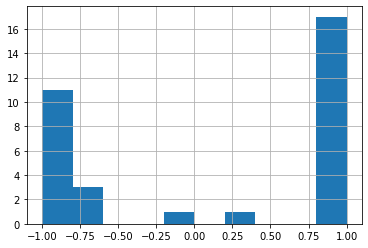

In [19]:
sentiment_hist(sentiments_2019)

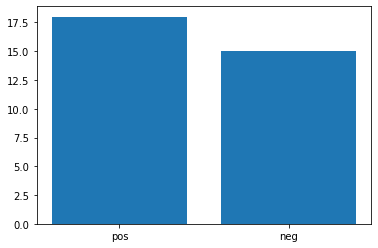

In [20]:
sentiment_bar(sentiments_2019)

In [21]:
# sentiments for 2020(covid)
sentiments_2020.head()

title  \
5  Chew Chor Meng thought of ending his life whil...   
6  Teetering on the edge: Woman rescued from ledg...   
7  Eleanor Lee: Why is it an insult if I turn out...   
8  Woman allegedly threatens suicide after quarre...   
9  'Right to disconnect' from work should be cons...   

                                                 url tags       date  \
5  https://www.asiaone.com/entertainment/chew-cho...  NIL 2020-11-13   
6  https://www.asiaone.com/singapore/teetering-ed...  NIL 2020-10-29   
7  https://www.asiaone.com/entertainment/eleanor-...  NIL 2020-10-16   
8  https://www.asiaone.com/singapore/woman-allege...  NIL 2020-09-04   
9  https://www.asiaone.com/singapore/right-discon...  NIL 2020-09-01   

                                             content  covid news_source  \
5  He once had it all � fame, money, success � bu...  False    Asia One   
6  A 42-year-old woman sitting on a ledge at the ...  False    Asia One   
7  When she was a little girl growing up in a sin...  False    Asia One   
8  A 50-year-old woman who allegedly threatened s...  False    Asia One   
9  Working from home has become a new norm for ma...   True    Asia One   

                                     cleaned_content  \
5  fame money success came crashing including hea...   
6  year old woman sitting ledge vertex building r...   
7  little girl growing single parent family mothe...   
8  year old woman allegedly threatened suicide qu...   
9  working home become new norm many since circui...   

                                               score  compound label  
5  {'neg': 0.105, 'neu': 0.772, 'pos': 0.122, 'co...    0.8611   pos  
6  {'neg': 0.012, 'neu': 0.881, 'pos': 0.107, 'co...    0.9413   pos  
7  {'neg': 0.093, 'neu': 0.797, 'pos': 0.11, 'com...    0.8466   pos  
8  {'neg': 0.113, 'neu': 0.796, 'pos': 0.091, 'co...   -0.7094   neg  
9  {'neg': 0.098, 'neu': 0.821, 'pos': 0.081, 'co...   -0.7713   neg

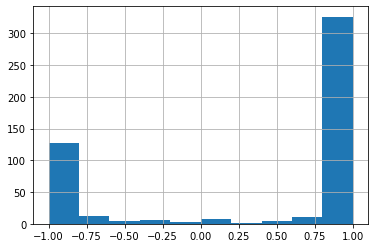

In [22]:
sentiment_hist(sentiments_2020)

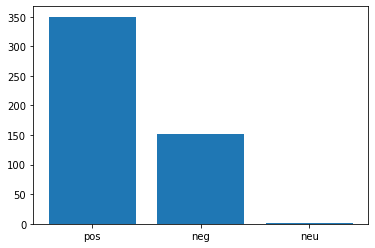

In [23]:
sentiment_bar(sentiments_2020)

In [24]:
# sentiments for 2021(late_covid)
sentiments_2021.head()

title  \
0  'It took months to see the end of the tunnel':...   
1  'Everyone watching makes me feel uneasy': Stud...   
2  Singapore Mental Health Film Festival 2021 ret...   
3  Woman, 19, rescued after sitting on 27th-floor...   
4  'I wanted to push the aircon out and jump down...   

                                                 url tags       date  \
0  https://www.asiaone.com/lifestyle/it-took-mont...  NIL 2021-06-05   
1  https://www.asiaone.com/singapore/everyone-wat...  NIL 2021-06-01   
2  https://www.asiaone.com/lifestyle/singapore-me...  NIL 2021-05-18   
3  https://www.asiaone.com/singapore/woman-19-res...  NIL 2021-04-09   
4  https://www.asiaone.com/lifestyle/i-wanted-pus...  NIL 2021-01-09   

                                             content  covid news_source  \
0  When she first started gymnastics at the age o...  False    Asia One   
1  These days, Natasha Osman would sit in front o...  False    Asia One   
2  The Covid-19 pandemic has heightened concerns ...   True    Asia One   
3  Residents in Sengkang craned their necks as th...  False    Asia One   
4  In his 30s and at the peak of his life and car...  False    Asia One   

                                     cleaned_content  \
0  first started gymnastics age eight joy koh rec...   
1  day natasha osman sit front laptop finger fidd...   
2  covid pandemic heightened concern mental healt...   
3  resident sengkang craned neck watched rescue t...   
4  peak life career daniel lim world unravelled d...   

                                               score  compound label  
0  {'neg': 0.087, 'neu': 0.744, 'pos': 0.168, 'co...    0.9974   pos  
1  {'neg': 0.081, 'neu': 0.854, 'pos': 0.065, 'co...   -0.9532   neg  
2  {'neg': 0.072, 'neu': 0.844, 'pos': 0.084, 'co...    0.5484   pos  
3  {'neg': 0.061, 'neu': 0.853, 'pos': 0.085, 'co...    0.6124   pos  
4  {'neg': 0.091, 'neu': 0.795, 'pos': 0.115, 'co...    0.9891   pos

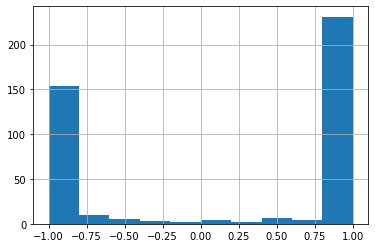

In [25]:
sentiment_hist(sentiments_2021)

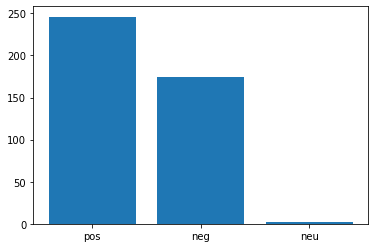

In [26]:
sentiment_bar(sentiments_2021)

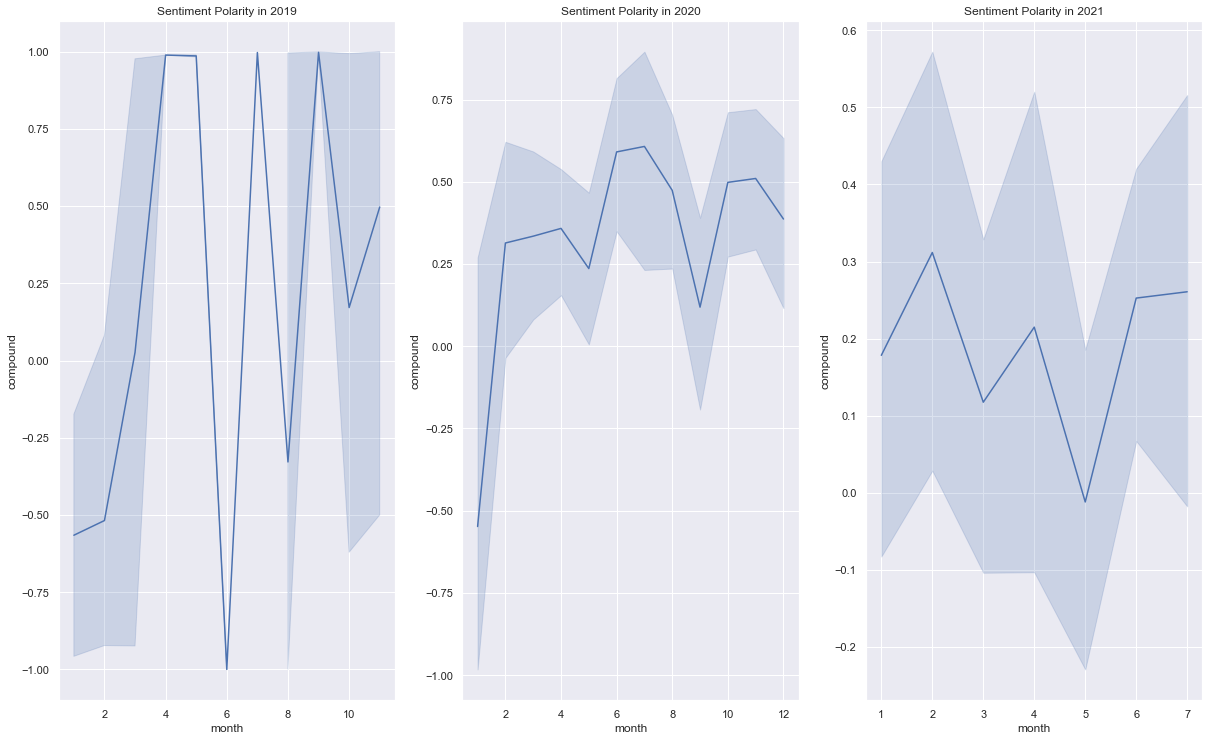

In [38]:
sentiments_2019["month"] = pd.DatetimeIndex(sentiments_2019['date']).month
sentiments_2020["month"] = pd.DatetimeIndex(sentiments_2020['date']).month
sentiments_2021["month"] = pd.DatetimeIndex(sentiments_2021['date']).month

fig, axs =plt.subplots(ncols=3)
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig.set_size_inches(20.5, 12.5, forward=True)
sns.lineplot(data=sentiments_2019, x="month", y=sentiments_2019["compound"] ,ax= axs[0]).set_title("Sentiment Polarity in 2019");
sns.lineplot(data=sentiments_2020, x="month", y=sentiments_2020["compound"], ax= axs[1]).set_title("Sentiment Polarity in 2020");
sns.lineplot(data=sentiments_2021, x="month", y=sentiments_2021["compound"] ,ax= axs[2]).set_title("Sentiment Polarity in 2021");